<a href="https://colab.research.google.com/github/xkumachii/pneumonia/blob/main/pneumonia_playaround_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras import Model, Input, models, layers
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2

In [2]:
! pip install -q kaggle
from google.colab import files

In [3]:
# 1.) check your kaggle account 
# 2.) go to edit profile
# 3.) create a new api token
# 4.) upload your kaggle.json file here
# 5.) for any retesting, keep your json file, and do not regenerate your api token unless absolutely needed
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kumachii","key":"88da3d2c0f72612f7a19151e3aef4786"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 161MB/s]
100% 2.29G/2.29G [00:20<00:00, 123MB/s]


In [6]:
!ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [7]:
import zipfile
zip_ref = zipfile.ZipFile("chest-xray-pneumonia.zip", "r")
zip_ref.extractall("files")
zip_ref.close()

In [8]:
!ls

chest-xray-pneumonia.zip  files  kaggle.json  sample_data


# X-ray Image Classification 

This notebook will demonstrate the diagnosis of pneumonia, and different types of pneumonia using Convolutional Neural Networks. 

The dataset we are working with is of various X-ray images of Chinese pediatric patients' lungs, sourced from Kaggle.


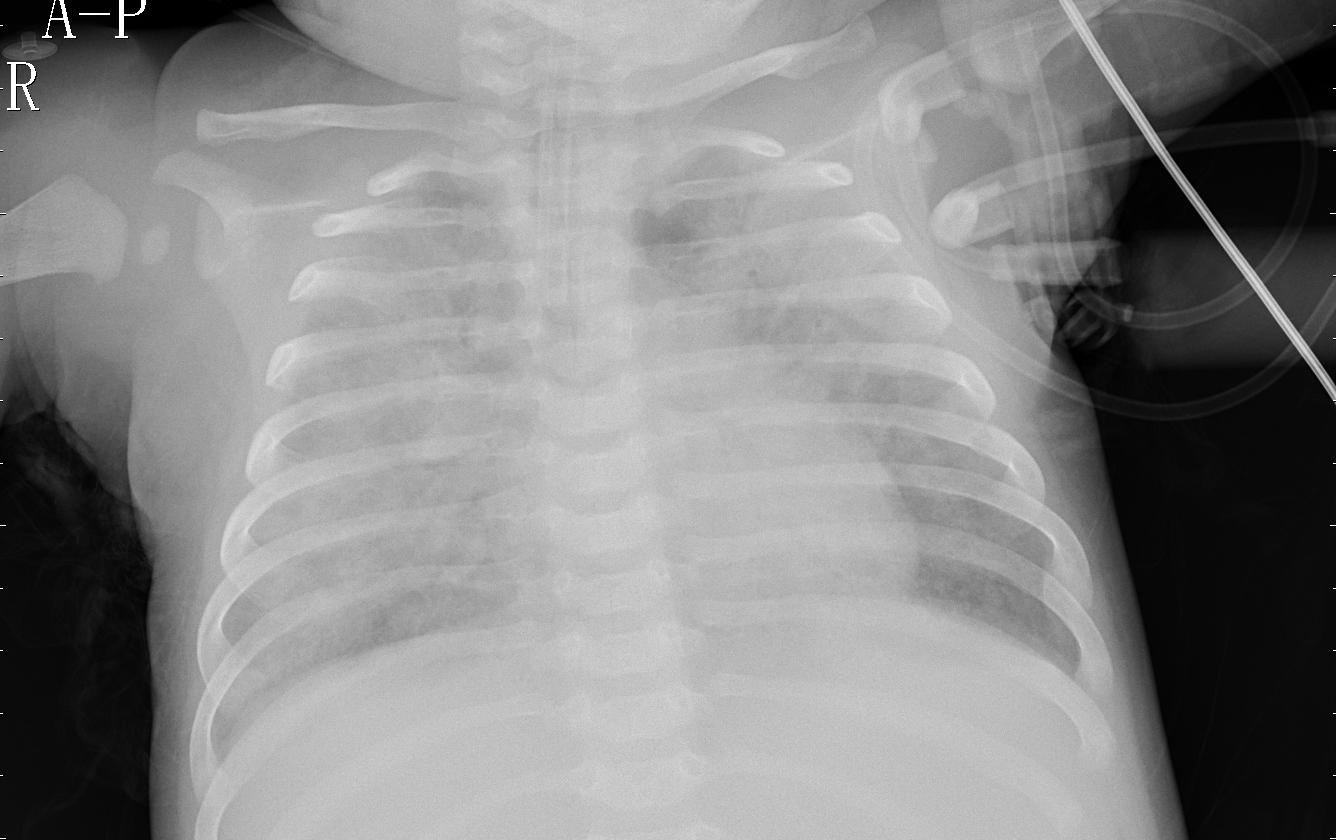

In [9]:
# The local path to the target image
img_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"

display(Image(img_path))

Stuff about preprocessing

# Binary Classification

For our first model, we will first take the images from our drive, and preprocess them into data that can be fed into a CNN.

For this section, we will focus on predicting whether a patient has pneumonia or not.

In [10]:
def load_data(path):

  imgs = []
  labels = np.array([])

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      img = image.load_img(temp_path + "/" + f, target_size=(150,150))
      x = image.img_to_array(img)
      imgs.append(x)
      labels = np.append(labels, [int(dir == 'PNEUMONIA')])
      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1
   

  imgs = np.asarray(imgs)
  # normalize our data from values 0-1
  imgs /= 255
  return imgs, labels


In [11]:
X_train, y_train = load_data("/content/files/chest_xray/train")
X_test, y_test = load_data("/content/files/chest_xray/test")

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0


In [12]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

## CNN

We will be testing our data on a simple CNN, with a dropout rate of 0.5 to prevent overfitting.

In [13]:
# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# f1
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [29]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

Because this is a binaru classification problem, the imbalance in our data can easily be circumvented by weighting our classes individually, in proportion to the amount of instances of pneumonia there are.

In [30]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

print(class_weight)
class_weights = {0:class_weight[0], 1:class_weight[1]}
print(class_weights)

[1.9448173  0.67303226]
{0: 1.9448173005219984, 1: 0.6730322580645162}


In order to improve the accuracy of our model, we will be generating data on the fly.

Again, to prevent overfitting, we have an early stopping callback in our training

In [31]:
batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

# todo: early stopping callback

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

history = model.fit(gen_data,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=20,callbacks=callback,validation_data=gen_test,validation_steps=X_test.shape[0]//batch_size,class_weight=class_weights)

Epoch 1/20
163/163 [==============================] - 27s 166ms/step - loss: 0.6610 - accuracy: 0.6108 - f1_m: 0.6438 - precision_m: 0.8037 - recall_m: 0.6043 - val_loss: 0.5863 - val_accuracy: 0.7089 - val_f1_m: 0.7567 - val_precision_m: 0.7930 - val_recall_m: 0.7382
Epoch 2/20
163/163 [==============================] - 27s 165ms/step - loss: 0.5029 - accuracy: 0.7607 - f1_m: 0.8130 - precision_m: 0.9229 - recall_m: 0.7511 - val_loss: 0.3852 - val_accuracy: 0.8125 - val_f1_m: 0.8456 - val_precision_m: 0.8573 - val_recall_m: 0.8367
Epoch 3/20
163/163 [==============================] - 27s 164ms/step - loss: 0.4297 - accuracy: 0.8066 - f1_m: 0.8514 - precision_m: 0.9359 - recall_m: 0.7993 - val_loss: 0.3690 - val_accuracy: 0.8174 - val_f1_m: 0.8508 - val_precision_m: 0.8498 - val_recall_m: 0.8576
Epoch 4/20
163/163 [==============================] - 27s 164ms/step - loss: 0.3840 - accuracy: 0.8372 - f1_m: 0.8751 - precision_m: 0.9469 - recall_m: 0.8313 - val_loss: 0.3522 - val_accuracy:

Trainining our model gives us around an 82% accuracy in regards to predicting whether a patient has pneumonia or not.

In [32]:
model.evaluate_generator(gen_test, 50, workers=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.35403767228126526,
 0.8445512652397156,
 0.8643921613693237,
 0.9182559251785278,
 0.81916344165802]

In [60]:
'''
for i in range (0, 400):
  preds = model.predict(np.expand_dims(X_test[i], axis=0))
  print("Chance of Pneumonia:", (preds))
'''

'\nfor i in range (0, 400):\n  preds = model.predict(np.expand_dims(X_test[i], axis=0))\n  print("Chance of Pneumonia:", (preds))\n'

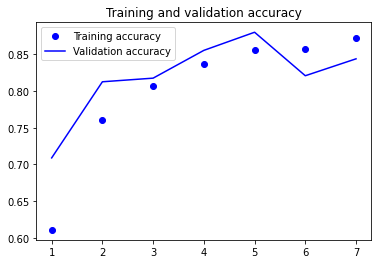

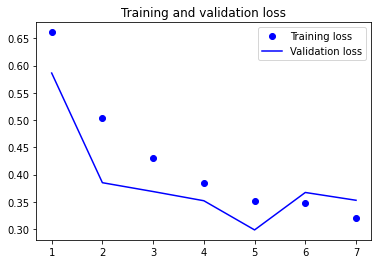

In [33]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

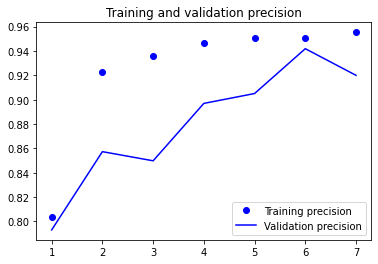

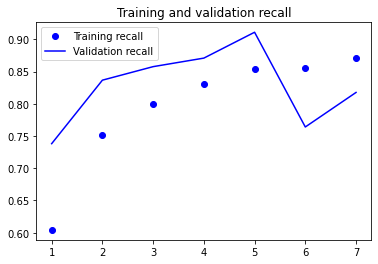

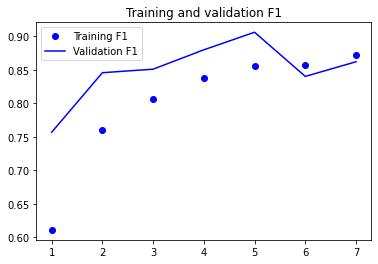

In [34]:
precision = history.history['precision_m']
recall = history.history['recall_m']
f1 = history.history['f1_m']
val_precision = history.history['val_precision_m']
val_recall = history.history['val_recall_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.show()

We will fetch two images from our test directory to test our model's prediction-making ability.

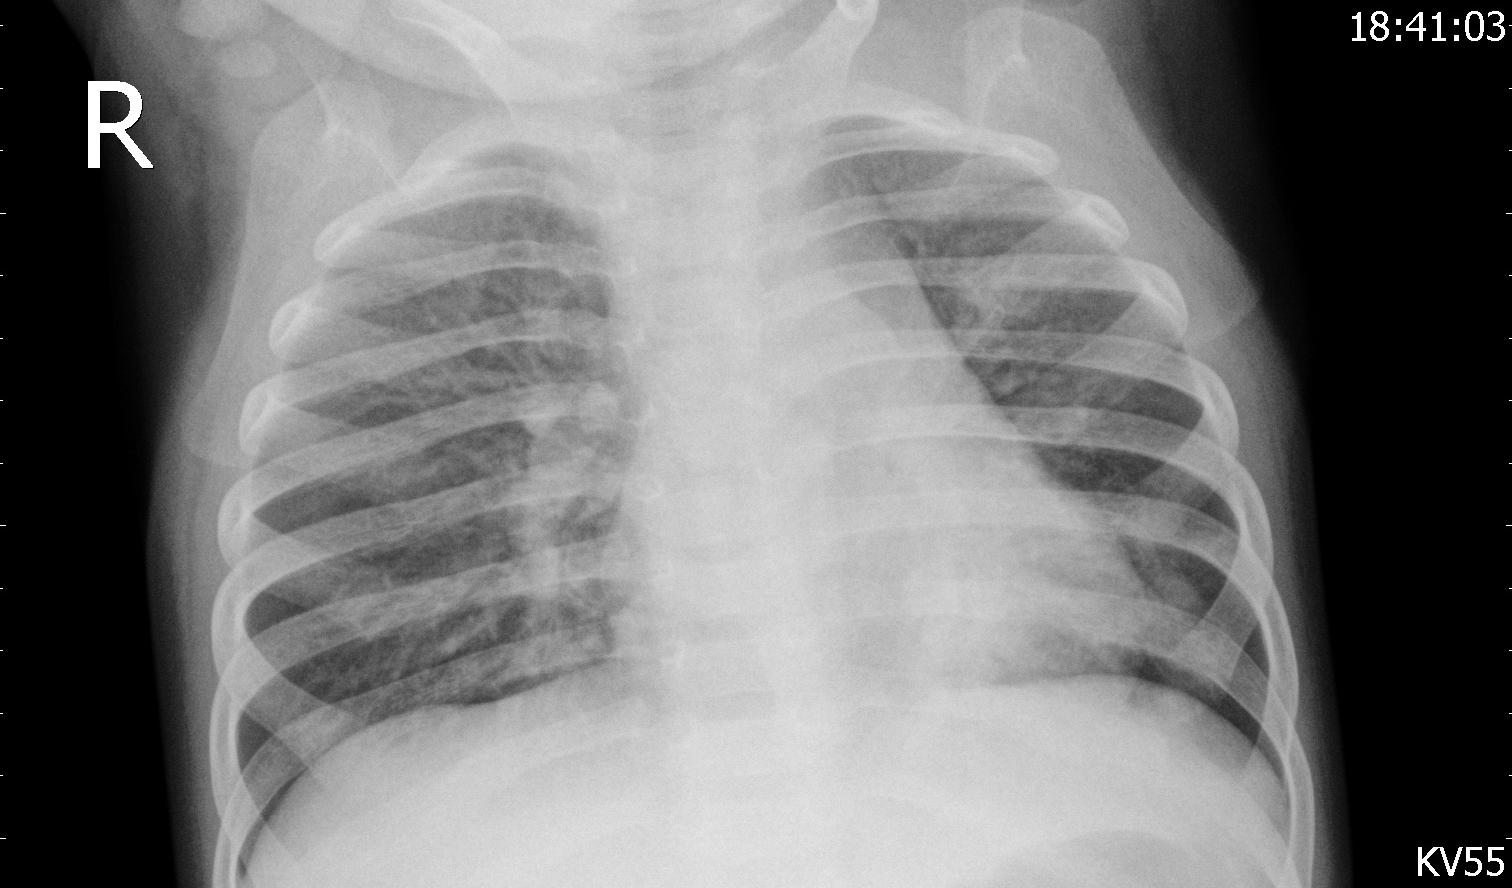

Chance of Pneumonia: [[0.96353257]]


In [37]:
img_path = "/content/files/chest_xray/test/PNEUMONIA/person1671_virus_2887.jpeg"

display(Image(img_path))

img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)
img = x

preds = model.predict(img)


print("Chance of Pneumonia:", (preds))

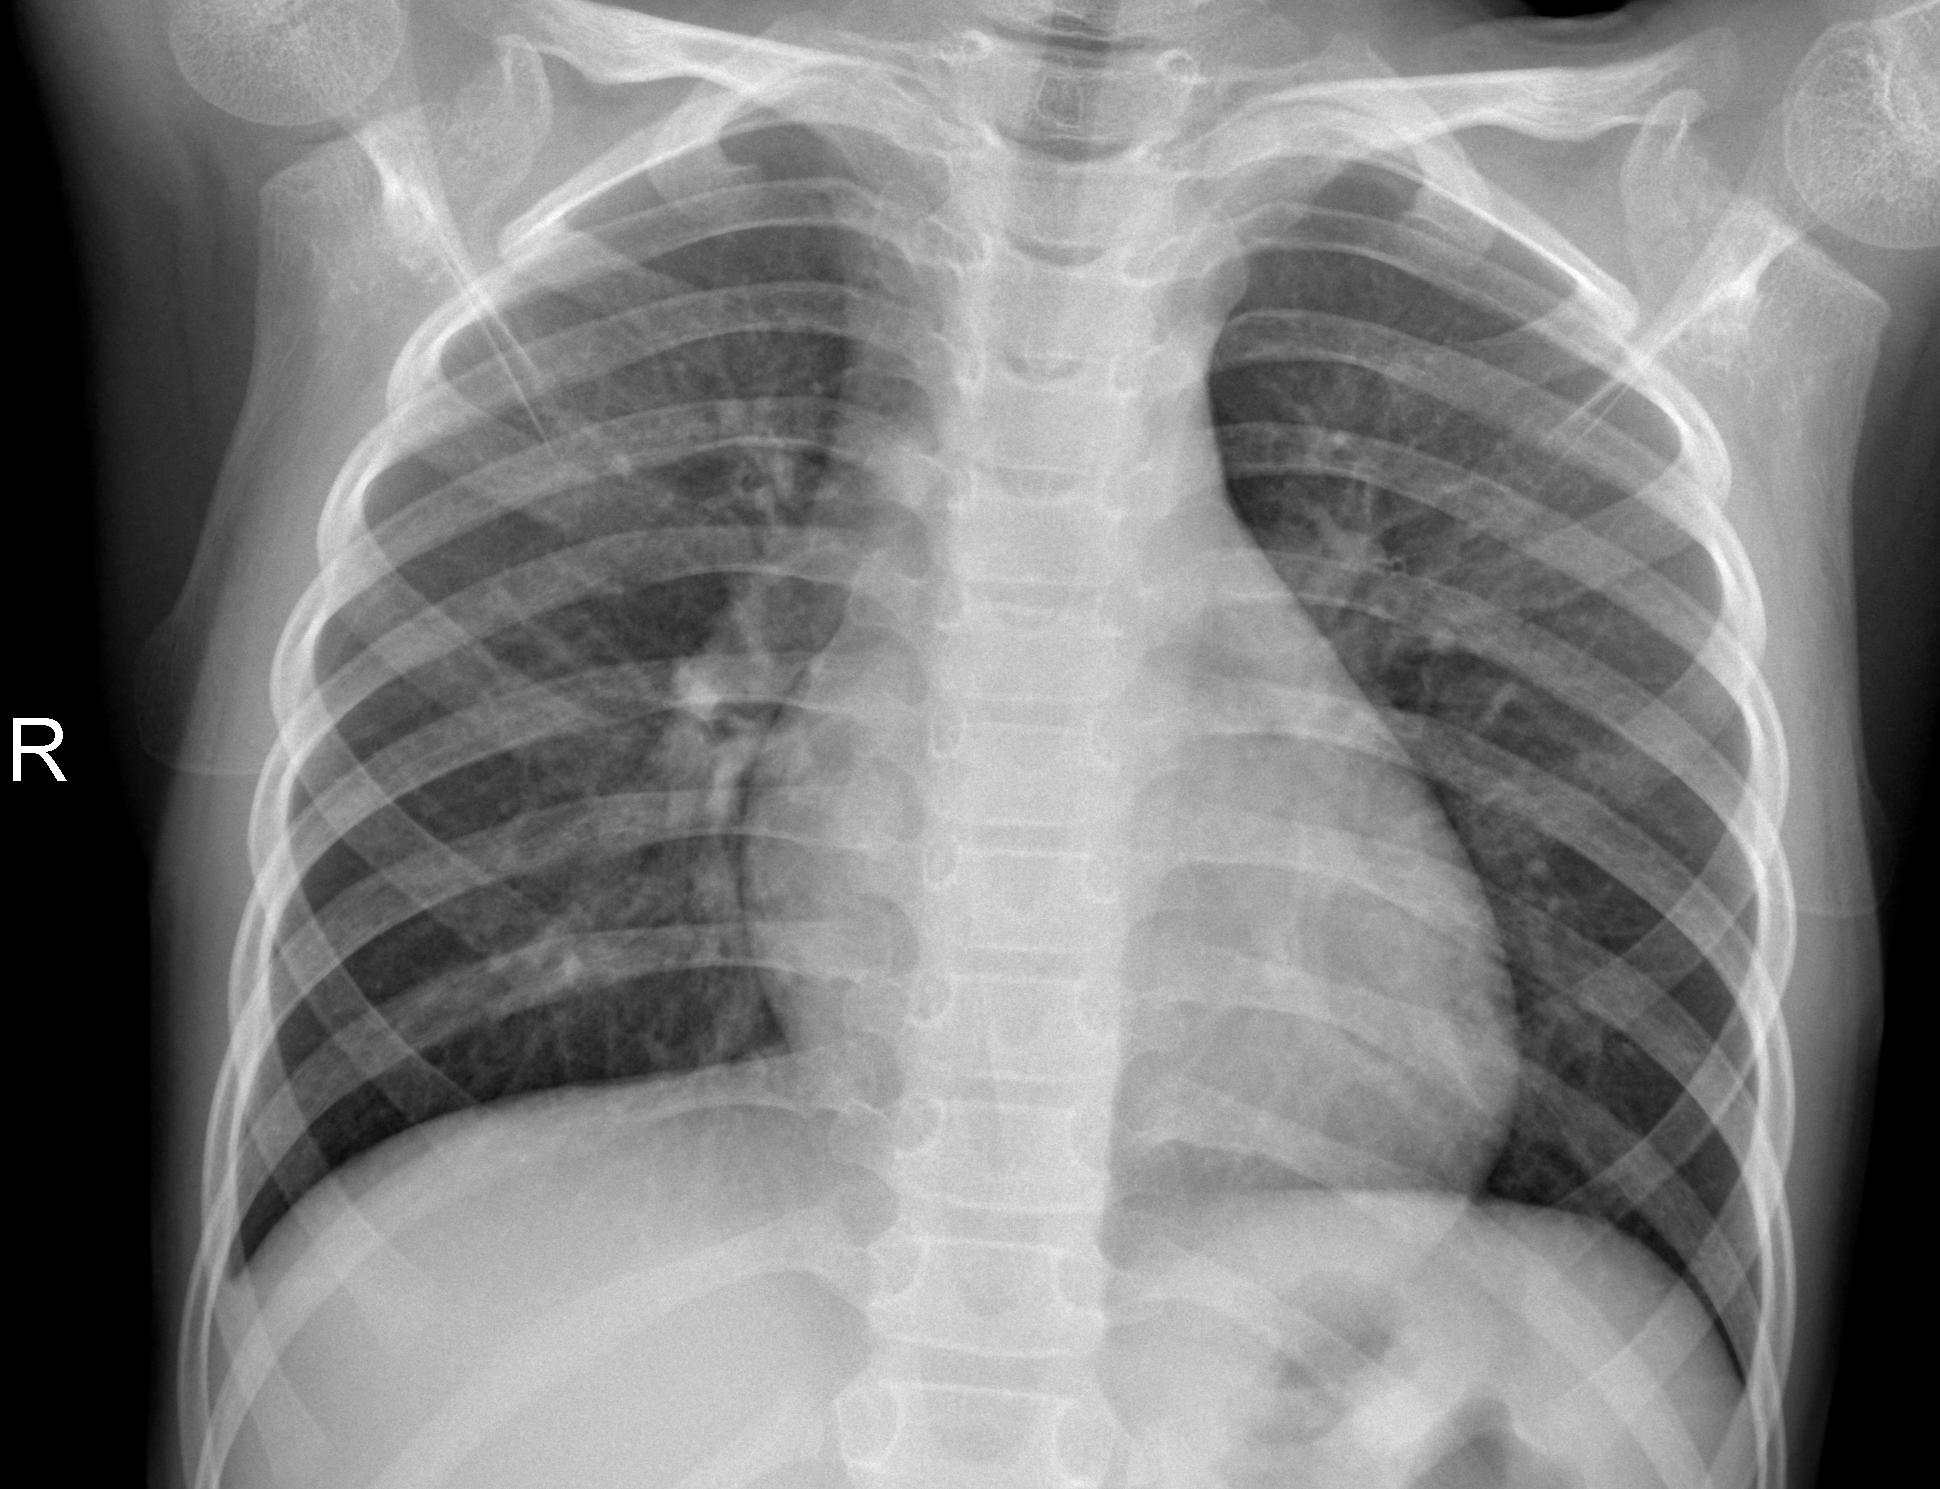

Chance of Pneumonia: [[0.00803998]]


In [38]:
img_path = "/content/files/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg"

display(Image(img_path))

img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)
img = x

preds = model.predict(img)


print("Chance of Pneumonia:", (preds))

This program predicts with 98% certainty that this patient has pneumonia.

We will now see what our model focuses on in when predicting a pneumonia case.

##Imbalanced Data
(placeholder for the time being)

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
print(class_weight)
class_weights = {0:class_weight[0], 1:class_weight[1]}
print(class_weights)

In [ ]:
!pip install imblearn 

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)

#X_train_S, y_train_S = smote.fit_sample(X_train,y_train)


print(X_train[1])

In [ ]:
from collections import Counter
print(Counter(y_train_S))

# HEAT MAPS!

We will be borrowing the Grad-CAM code on Keras's website for our following visuals.

source: https://keras.io/examples/vision/grad_cam/

In [39]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array /= 255
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def superimposition(img_path, heatmap, save_img_as):
  img = image.load_img(img_path)
  img = image.img_to_array(img)

  heatmap = np.uint8(255 * heatmap)

  jet = cm.get_cmap("jet")

  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = image.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = image.array_to_img(superimposed_img)

  save_path = save_img_as
  superimposed_img.save(save_path)

  # Display Grad CAM
  display(Image(save_path))

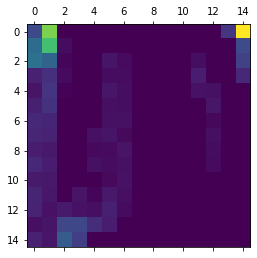

In [45]:
img_path = "/content/files/chest_xray/test/PNEUMONIA/person1671_virus_2887.jpeg"

img_array = get_img_array(img_path, size=(150,150))

last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

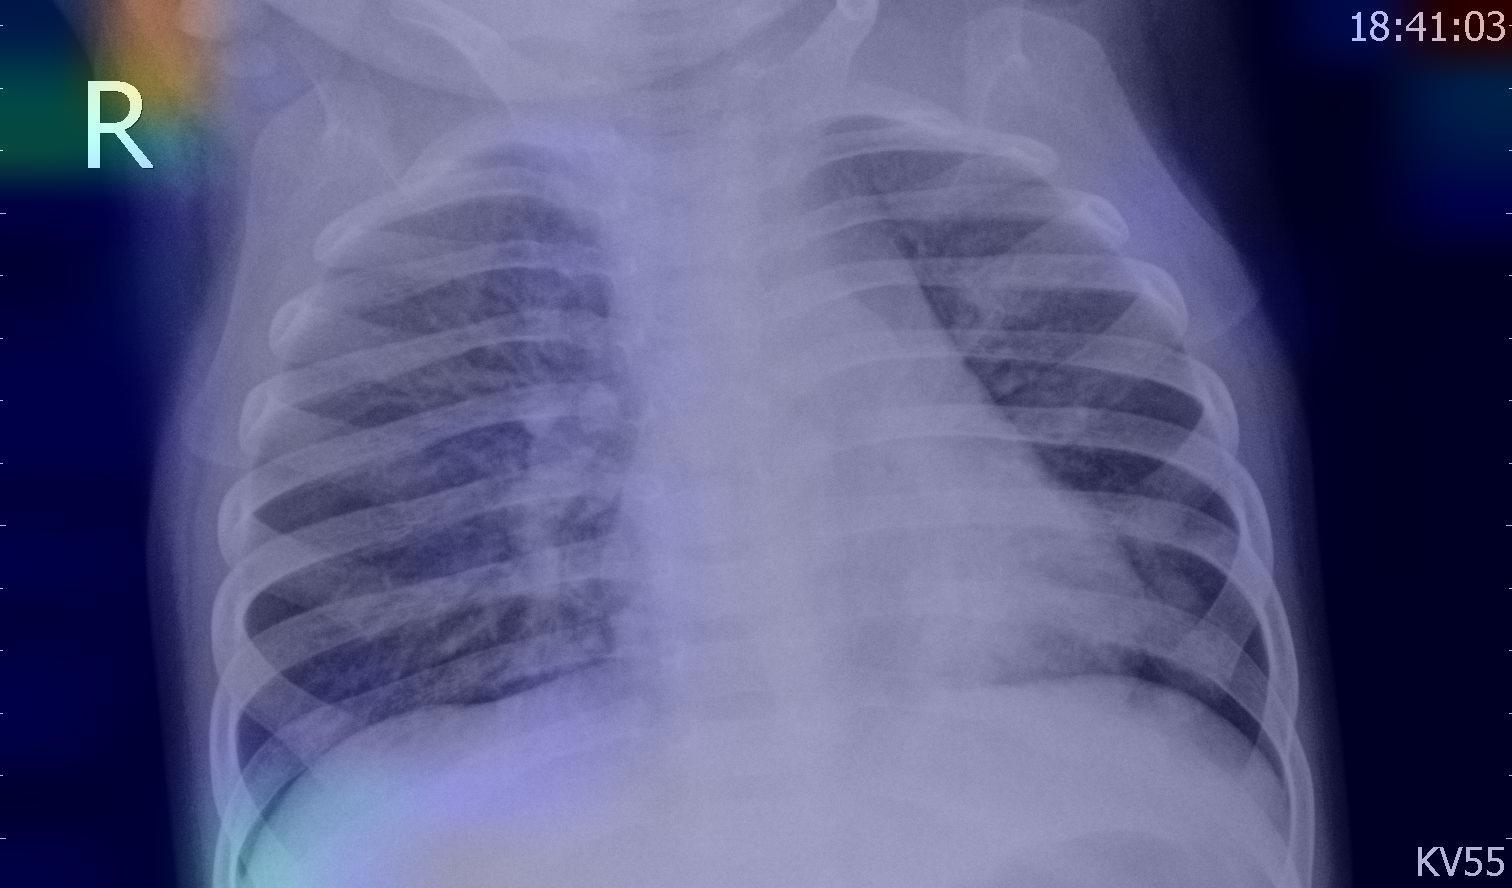

In [42]:
superimposition("/content/files/chest_xray/test/PNEUMONIA/person1671_virus_2887.jpeg", heatmap, "binary_pneumonia_case.jpeg")

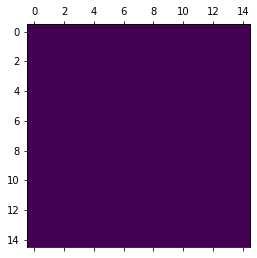

In [47]:
img_path = "/content/files/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg"

img_array = get_img_array(img_path, size=(150,150))

last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

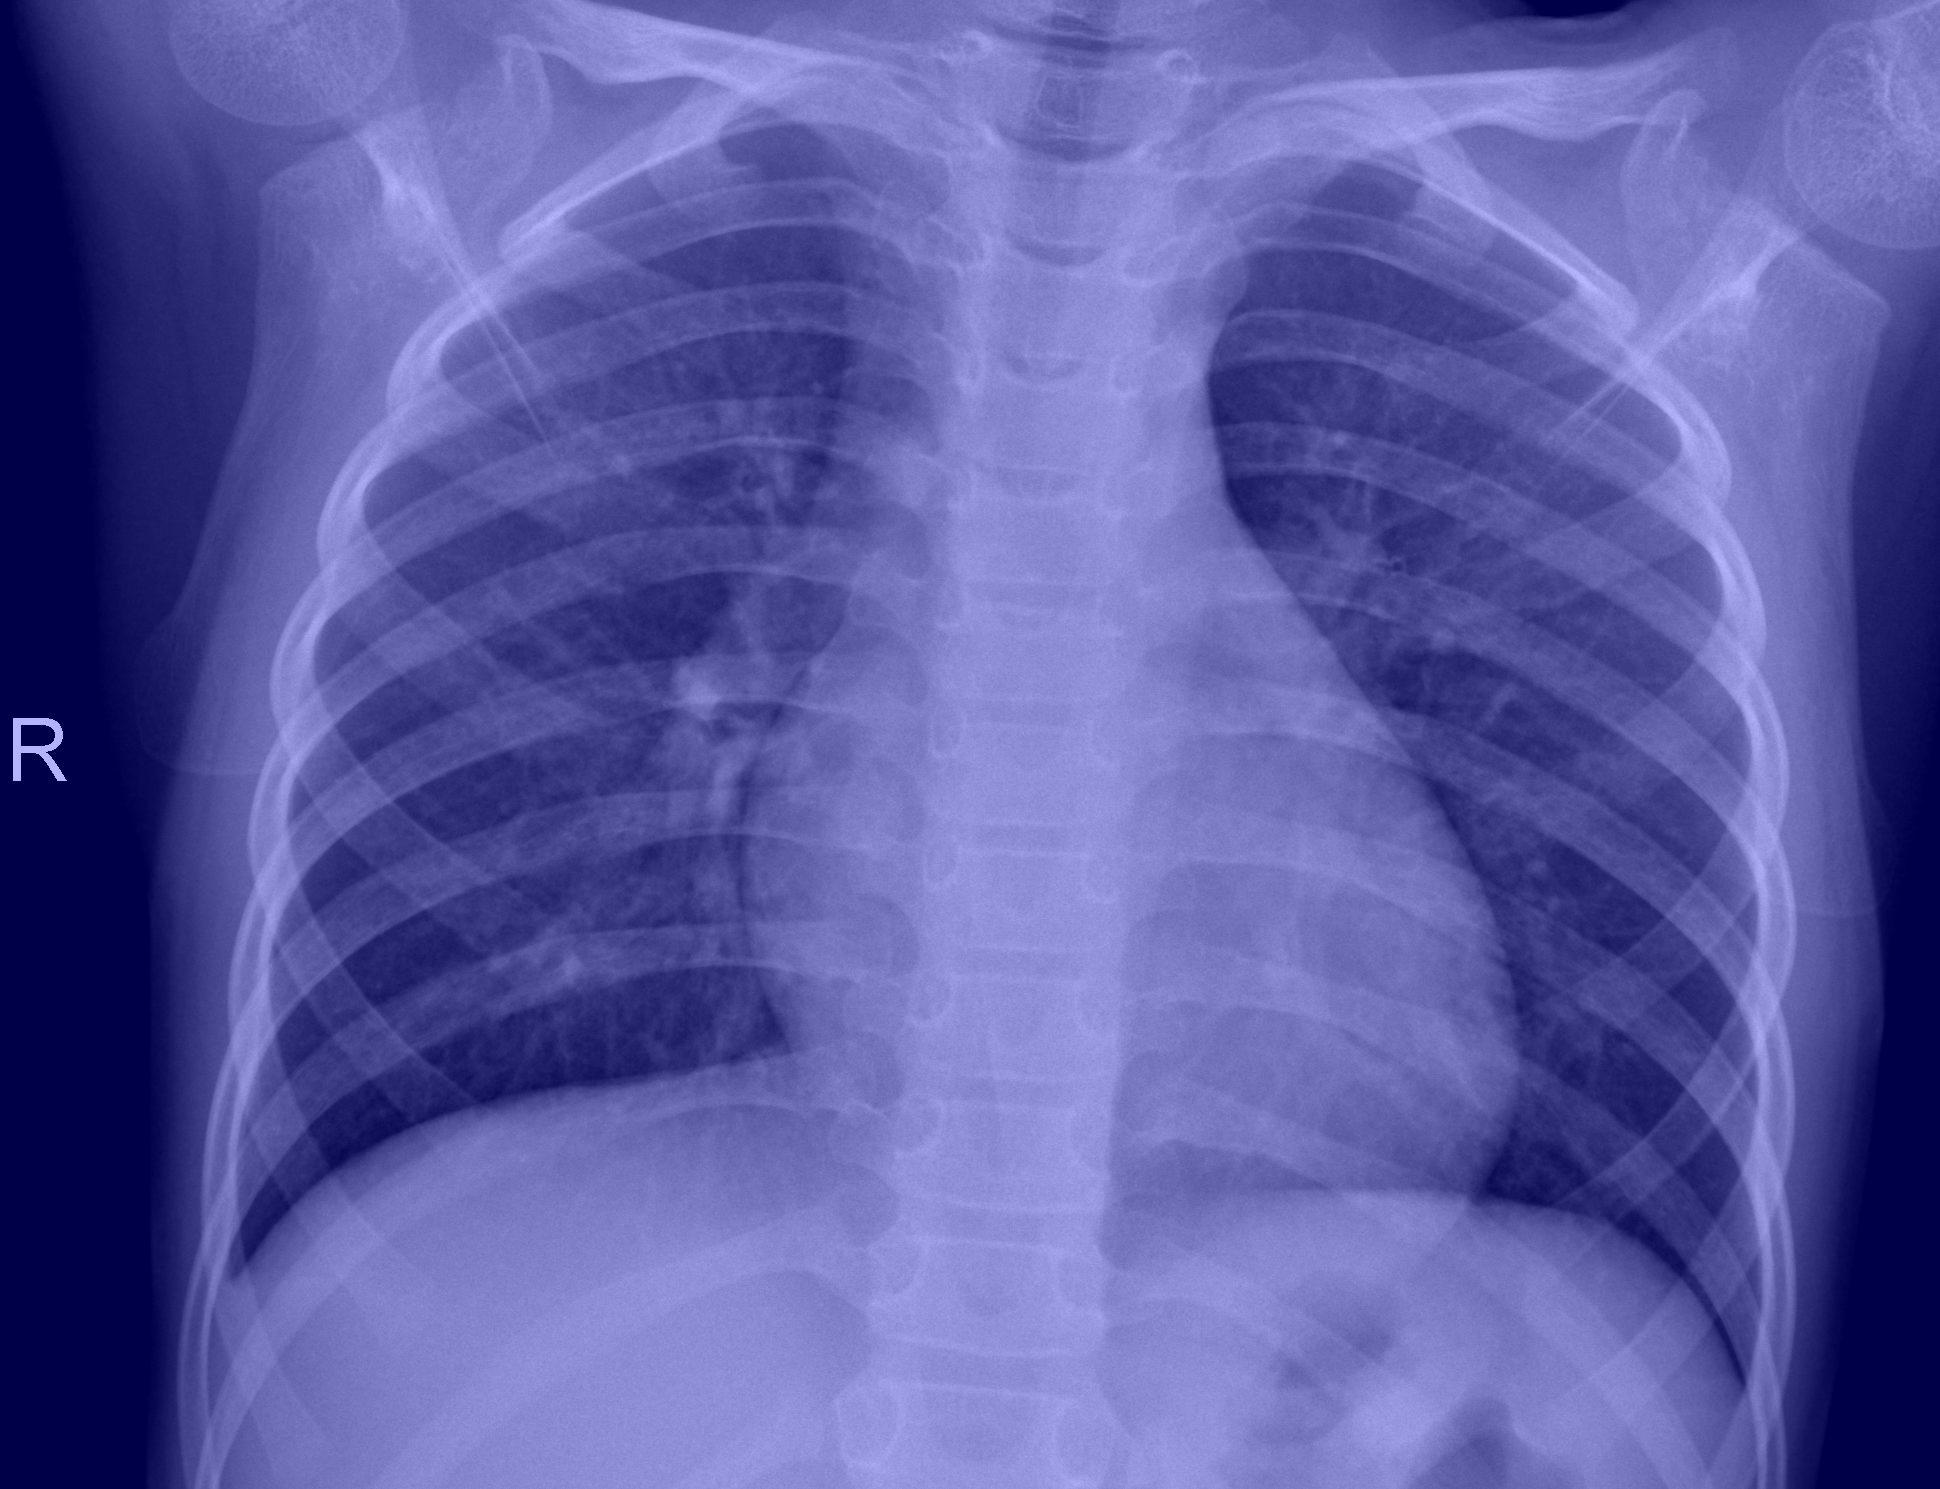

In [48]:
superimposition("/content/files/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg", heatmap, "binary_normal_case.jpeg")

The superimposed heatmap lights up in the patients' chest cavity, showing where in the picture this model focuses on.
 
 (todo: a non-pneumonia pic)

# Three-Way Classification

We will now be processing our data such that we will also be taking into consideration, the type of pneumonia one can be diagnosed with -- bacterial and viral.

In [49]:
def load_data_2(path):
  imgs = []
  labels = []

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      img = image.load_img(temp_path + "/" + f, target_size=(150,150))
      x = image.img_to_array(img)
      imgs.append(x)

      # one-hot encoded labels
      labels.append([int(not ('bacteria' in f or 'virus' in f)), int('bacteria' in f), int('virus' in f)])


      # to check progress:
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1

      

  imgs = np.asarray(imgs)
  labels = np.asarray(labels)
  # normalize our data from values 0-1
  imgs /= 255
  print(imgs.shape) # left there for debug
  return imgs, labels

In [50]:
X_train, y_train = load_data_2("/content/files/chest_xray/train")
X_test, y_test = load_data_2("/content/files/chest_xray/test")
print(y_test)

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
(5216, 150, 150, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 150, 150, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


We will now prepare our dataset for easy photo access for our cluster analysis.

In [51]:
# prepare three-way categorical data directories for training
%cd files/chest_xray/train
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
!ls

# prepare three-way categorical data directories for testing
%cd ../test
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
%cd ../../..

/content/files/chest_xray/train
/content/files/chest_xray/train/PNEUMONIA
/content/files/chest_xray/train
BACTERIA  NORMAL  VIRUS
/content/files/chest_xray/test
/content/files/chest_xray/test/PNEUMONIA
/content/files/chest_xray/test
/content


In [ ]:
'''
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

batch_size = 128

traingen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True

)

testgen = ImageDataGenerator(rescale=1./255)

train_generator = traingen.flow_from_directory(
        "/content/files/chest_xray/train",
        target_size=(150, 150),
        classes=["NORMAL", "BACTERIA", "VIRUS"],
        batch_size=32,
        class_mode='categorical')
validation_generator = testgen.flow_from_directory(
        "/content/files/chest_xray/test",
        target_size=(150, 150),
        classes=["NORMAL", "BACTERIA", "VIRUS"],
        batch_size=32,
        class_mode='categorical')
'''

'\nfrom keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img\n\nbatch_size = 128\n\ntraingen = ImageDataGenerator(\n    rescale= 1./255,\n    rotation_range =45,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip = True\n\n)\n\ntestgen = ImageDataGenerator(rescale=1./255)\n\ntrain_generator = traingen.flow_from_directory(\n        "/content/files/chest_xray/train",\n        target_size=(150, 150),\n        classes=["NORMAL", "BACTERIA", "VIRUS"],\n        batch_size=32,\n        class_mode=\'categorical\')\nvalidation_generator = testgen.flow_from_directory(\n        "/content/files/chest_xray/test",\n        target_size=(150, 150),\n        classes=["NORMAL", "BACTERIA", "VIRUS"],\n        batch_size=32,\n        class_mode=\'categorical\')\n'

Because we cannot simply weight our data in proportion to how many instances of a case there are, we will be oversampling to equalize our data.

In [59]:
bacterial_indices = np.array([i[0] == 0 and i[1] == 1 and i[2] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 0 and i[2] == 1 for i in y_train])
normal_indices = np.array([i[0] == 1 and i[1] == 0 and i[2] == 0 for i in y_train])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

train viral pneumonia cases: 2500
train bacterial pneumonia cases: 2530
train normal cases: 2500


Since there is a significant imbalance of bacterial data compared to normal and viral data, we will be oversampling the normal and viral data accordingly -- to 2500 entries.

In [53]:
X_train_normals, y_train_normals = X_train[normal_indices], y_train[normal_indices]
X_train_viral, y_train_viral = X_train[viral_indices], y_train[viral_indices]

In [54]:
# this seed here is to maintain a deterministic runtime
np.random.seed(42)

normal_oversampling_indices = np.random.choice(X_train_normals.shape[0], 2500 - X_train_normals.shape[0])
viral_oversampling_indices = np.random.choice(X_train_viral.shape[0], 2500 - X_train_viral.shape[0])

print(normal_oversampling_indices)
print(viral_oversampling_indices)

[1126  860 1294 ...  312  758  442]
[ 327 1077  760 ...  385  404  245]


In [55]:
X_train_concatenate_normal, y_train_concatenate_normal = X_train_normals[normal_oversampling_indices], y_train_normals[normal_oversampling_indices]
X_train_concatenate_viral, y_train_concatenate_viral = X_train_viral[viral_oversampling_indices], y_train_viral[viral_oversampling_indices]

# new X_train
X_train = np.concatenate((X_train, X_train_concatenate_normal))
X_train = np.concatenate((X_train, X_train_concatenate_viral))


# new Y_train
y_train = np.concatenate((y_train, y_train_concatenate_normal))
y_train = np.concatenate((y_train, y_train_concatenate_viral))

print(X_train.shape)

(7530, 150, 150, 3)


We now have a relatively equal number of data.

In [56]:
bacterial_indices = np.array([i[0] == 0 and i[1] == 1 and i[2] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 0 and i[2] == 1 for i in y_train])
normal_indices = np.array([i[0] == 1 and i[1] == 0 and i[2] == 0 for i in y_train])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

train viral pneumonia cases: 2500
train bacterial pneumonia cases: 2530
train normal cases: 2500


We will now test our three-way classification system with the same model we have used for our binary classification system -- the only difference is the usage of softmax instead of sigmoid.

In [62]:
K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3,activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [65]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history = model.fit(X_train, y_train,batch_size=32,epochs=35,callbacks=callback,validation_data=(X_test, y_test))

Epoch 1/35
236/236 [==============================] - 3s 14ms/step - loss: 0.3923 - accuracy: 0.8240 - f1_m: 0.8229 - precision_m: 0.8312 - recall_m: 0.8149 - val_loss: 1.4372 - val_accuracy: 0.6795 - val_f1_m: 0.6809 - val_precision_m: 0.6839 - val_recall_m: 0.6781
Epoch 2/35
236/236 [==============================] - 3s 14ms/step - loss: 0.3616 - accuracy: 0.8424 - f1_m: 0.8428 - precision_m: 0.8486 - recall_m: 0.8372 - val_loss: 2.0403 - val_accuracy: 0.6763 - val_f1_m: 0.6781 - val_precision_m: 0.6814 - val_recall_m: 0.6750
Epoch 3/35
236/236 [==============================] - 3s 14ms/step - loss: 0.3401 - accuracy: 0.8487 - f1_m: 0.8490 - precision_m: 0.8536 - recall_m: 0.8447 - val_loss: 1.5383 - val_accuracy: 0.7340 - val_f1_m: 0.7319 - val_precision_m: 0.7394 - val_recall_m: 0.7250
Epoch 4/35
236/236 [==============================] - 3s 14ms/step - loss: 0.3214 - accuracy: 0.8612 - f1_m: 0.8601 - precision_m: 0.8634 - recall_m: 0.8570 - val_loss: 1.8616 - val_accuracy: 0.7420 

Because oversampling alone does not increase the validation accuracy by much, we will be using a combination of oversampling and data generation in order to improve the accuracy of our model.

In [66]:
batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history = model.fit(gen_data,steps_per_epoch=(X_train.shape[0]//batch_size),epochs=35,callbacks=callback,validation_data=gen_test,validation_steps=X_test.shape[0]//batch_size)

Epoch 1/35
235/235 [==============================] - 39s 166ms/step - loss: 0.9609 - accuracy: 0.5235 - f1_m: 0.3758 - precision_m: 0.6266 - recall_m: 0.2813 - val_loss: 0.6809 - val_accuracy: 0.7007 - val_f1_m: 0.6809 - val_precision_m: 0.8019 - val_recall_m: 0.5938
Epoch 2/35
235/235 [==============================] - 39s 165ms/step - loss: 0.8067 - accuracy: 0.6296 - f1_m: 0.5677 - precision_m: 0.6967 - recall_m: 0.4852 - val_loss: 0.6246 - val_accuracy: 0.7993 - val_f1_m: 0.7693 - val_precision_m: 0.8791 - val_recall_m: 0.6875
Epoch 3/35
235/235 [==============================] - 38s 163ms/step - loss: 0.7618 - accuracy: 0.6600 - f1_m: 0.6103 - precision_m: 0.7105 - recall_m: 0.5408 - val_loss: 0.7098 - val_accuracy: 0.7418 - val_f1_m: 0.7259 - val_precision_m: 0.8703 - val_recall_m: 0.6250
Epoch 4/35
235/235 [==============================] - 38s 163ms/step - loss: 0.7327 - accuracy: 0.6707 - f1_m: 0.6394 - precision_m: 0.7200 - recall_m: 0.5790 - val_loss: 0.5641 - val_accuracy:

We have an val_accuracy of 84%.

In [67]:
model.evaluate_generator(gen_test, 50, workers=1)

[0.4790239632129669,
 0.8461538553237915,
 0.839440643787384,
 0.8826359510421753,
 0.801562488079071]

In [68]:
'''
for i in range (0, 400):
  preds = model.predict(np.expand_dims(X_test[i], axis=0))
  print("Predicted:", (preds))
'''

'\nfor i in range (0, 400):\n  preds = model.predict(np.expand_dims(X_test[i], axis=0))\n  print("Predicted:", (preds))\n'

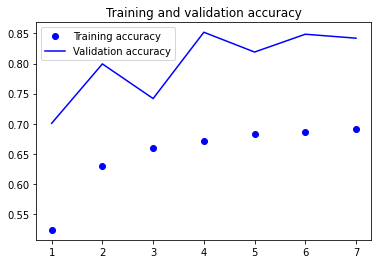

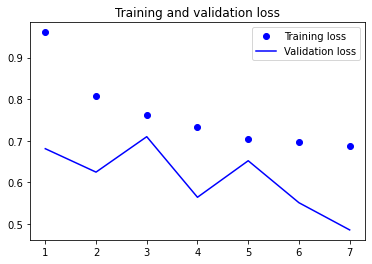

In [69]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

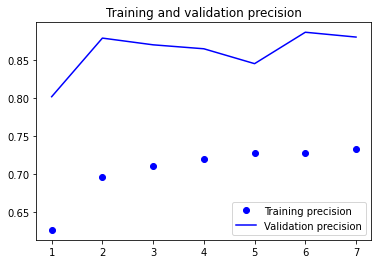

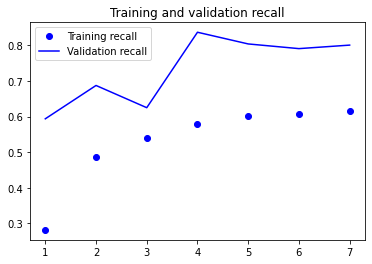

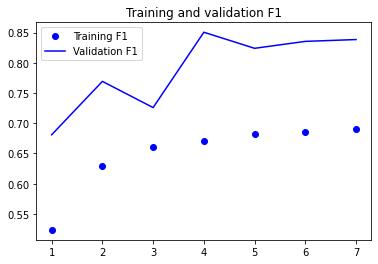

In [70]:
precision = history.history['precision_m']
recall = history.history['recall_m']
f1 = history.history['f1_m']
val_precision = history.history['val_precision_m']
val_recall = history.history['val_recall_m']
val_f1 = history.history['val_f1_m']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend()

plt.show()

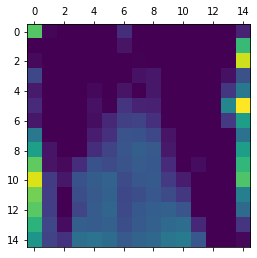

Predicted: [[0.0187766  0.5940495  0.38717383]]


In [84]:
img_path = "/content/files/chest_xray/train/BACTERIA/person1945_bacteria_4872.jpeg"

img_array = get_img_array(img_path, size=(150,150))

last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

preds = model.predict(img)

# todo: get those labels up
# order: normal, bacterial, viral
print("Predicted:", (preds))

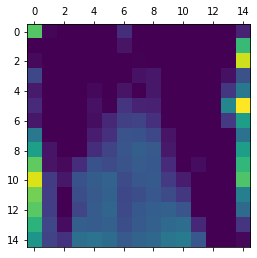

In [83]:
img_array = get_img_array(img_path, size=(150,150))

last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

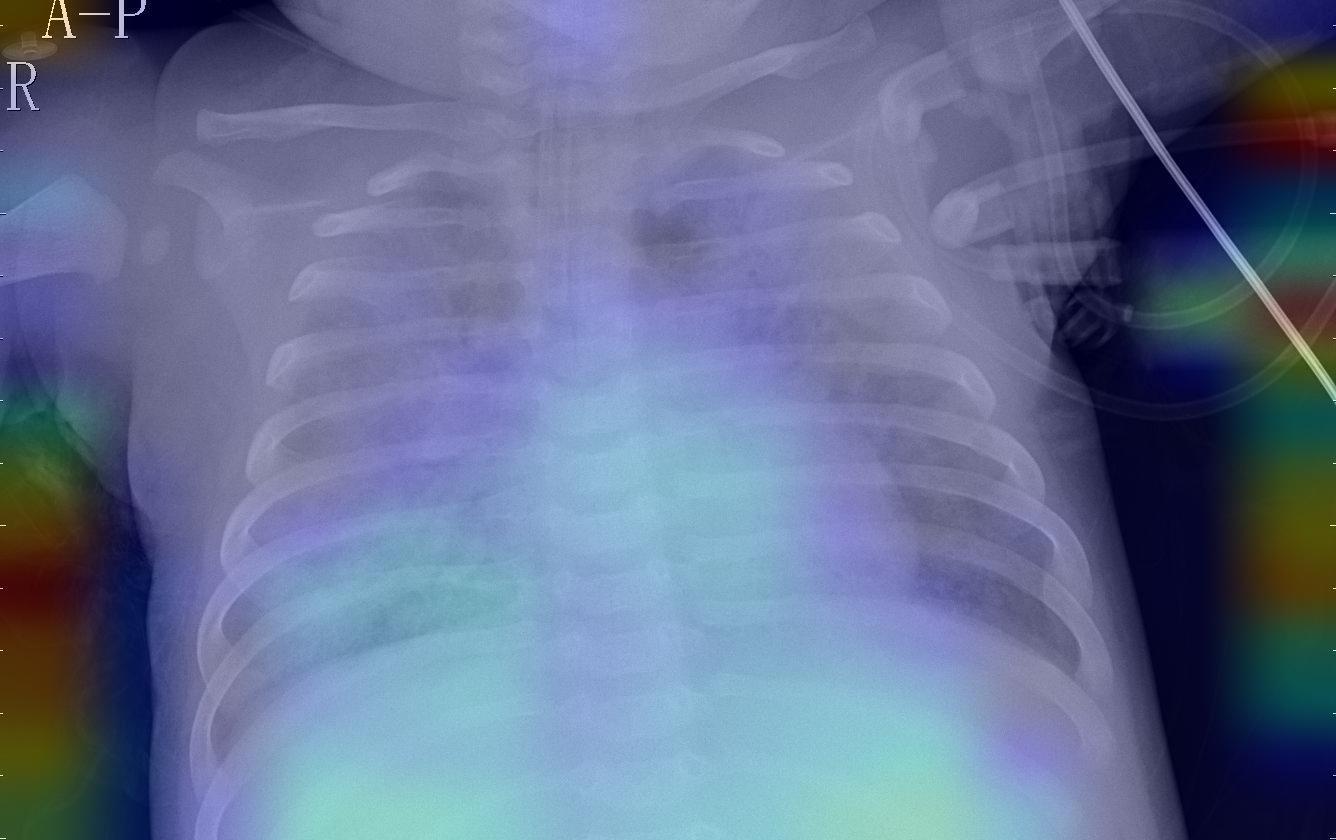

In [86]:
superimposition("/content/files/chest_xray/train/BACTERIA/person1945_bacteria_4872.jpeg",heatmap,"three_way_bacteria_case.jpeg")

# MORE HEAT MAPS

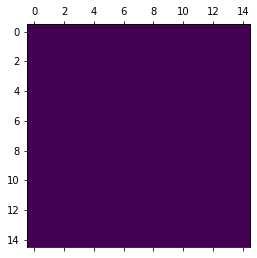

In [ ]:
last_conv_layer_name = "conv2d_3"
classifier_layer_names = [
    "activation_3", "max_pooling2d_3", "flatten", "dense", "activation_4", "dropout", "dense_1"
]



last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
# heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)

In [ ]:
#SALIENCY